In [5]:
# !pip install kaggle
# !pip install pyarrow
# !pip install statsmodels
# !pip install xgboost
# Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/&& mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
#!kaggle competitions download -c optiver-realized-volatility-prediction
#! mkdir input
#! mv optiver-realized-volatility-prediction.zip input/
! cd input && unzip -o optiver-realized-volatility-prediction.zip
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

files = []
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))
print(files[0:10])

Archive:  optiver-realized-volatility-prediction.zip
  inflating: book_test.parquet/stock_id=0/7832c05caae3489cbcbbb9b02cf61711.parquet  
  inflating: book_train.parquet/stock_id=0/c439ef22282f412ba39e9137a3fdabac.parquet  
  inflating: book_train.parquet/stock_id=1/31a1c5cd6d8546b383d10373db762236.parquet  
  inflating: book_train.parquet/stock_id=10/d671bb2b87f447d4ba3fa4b18b3656f9.parquet  
  inflating: book_train.parquet/stock_id=100/9495f2c64cee42078601dee7408e3c36.parquet  
  inflating: book_train.parquet/stock_id=101/dbbf6dc725ee4bcb8656c427165c888d.parquet  
  inflating: book_train.parquet/stock_id=102/9d16ca233fea42c7a8ec91d621ca113a.parquet  
  inflating: book_train.parquet/stock_id=103/cc7984f01a8747299339cb441632d6c0.parquet  
  inflating: book_train.parquet/stock_id=104/6875618fb8144a80a033ae8de7809493.parquet  
  inflating: book_train.parquet/stock_id=105/a37b8bf4be2e4fa5b3ea63b7c4240d3d.parquet  
  inflating: book_train.parquet/stock_id=107/0a58f297fa7b471a8c39b79420f999

  inflating: book_train.parquet/stock_id=8/e40cd587617e4bfc86f0125aef383932.parquet  
  inflating: book_train.parquet/stock_id=80/705f7c3bde584dadba222d4ef6f7973e.parquet  
  inflating: book_train.parquet/stock_id=81/3736a90d604d4b8eaa15c6eb5f83fd8c.parquet  
  inflating: book_train.parquet/stock_id=82/ae830997c75f405986957af2984493f3.parquet  
  inflating: book_train.parquet/stock_id=83/4c10ab2a0f324a1189af12bd5458ef15.parquet  
  inflating: book_train.parquet/stock_id=84/53e9faaf11e745debb3c246acea61a84.parquet  
  inflating: book_train.parquet/stock_id=85/1b7a536b29724b60990ee6c368f1fbf0.parquet  
  inflating: book_train.parquet/stock_id=86/6ecdb8f8c4da483b8fd3fbdf6aee4381.parquet  
  inflating: book_train.parquet/stock_id=87/670ab2a9e8b548bdaa8b9f8bc9057331.parquet  
  inflating: book_train.parquet/stock_id=88/2c4ed518efb54a4f880a0f945c317fae.parquet  
  inflating: book_train.parquet/stock_id=89/a1cd471332f24761a90f6fadb8b54ccf.parquet  
  inflating: book_train.parquet/stock_id=9/8

  inflating: trade_train.parquet/stock_id=59/2653e96292d24c64b27c0b70de53b2f9.parquet  
  inflating: trade_train.parquet/stock_id=6/fcf85e8ee88944d7bcbc9fc9862ee3f1.parquet  
  inflating: trade_train.parquet/stock_id=60/ae35d2b5825d4f1c9b52f462862eae04.parquet  
  inflating: trade_train.parquet/stock_id=61/fab533c5a5a741d8929f391890a4d54d.parquet  
  inflating: trade_train.parquet/stock_id=62/8df3e07ae2b74ad19fd98d4b9acfcbf2.parquet  
  inflating: trade_train.parquet/stock_id=63/107939e77b8642a3a222419adc1ae0f2.parquet  
  inflating: trade_train.parquet/stock_id=64/338f683c092048ebaba1708e6dd1e774.parquet  
  inflating: trade_train.parquet/stock_id=66/c544fc443c6042ab9bb4ddec47179a3d.parquet  
  inflating: trade_train.parquet/stock_id=67/703c7481d60a43839cd67d09fa3ad6c2.parquet  
  inflating: trade_train.parquet/stock_id=68/b077ddd5f9304972b0595a31899d4f8a.parquet  
  inflating: trade_train.parquet/stock_id=69/bcd636dbdd0b42bea8ad6a62a0d1fdf4.parquet  
  inflating: trade_train.parquet/

Build models that predict short-term volatility for hundreds of stocks across different sectors. You will have hundreds of millions of rows of highly granular financial data at your fingertips, with which you will design your model forecasting volatility over 10-minute periods. Your models will be evaluated against real market data collected in the three-month evaluation period after training.

target - The realized volatility computed over the 10 minute window following the feature data under the same stock/time_id. There is no overlap between feature and target data. You can find more info in our tutorial notebook.
**we only need to predict for stock id 0**

row_id - Unique identifier for the submission row. There is one row for each existing time ID/stock ID pair. Each time window is not necessarily containing every individual stock.


stock_id - ID code for the stock. Not all stock IDs exist in every time bucket. Parquet coerces this column to the categorical data type when loaded; you may wish to convert it to int8.

time_id - ID code for the time bucket. Time IDs are not necessarily sequential but are consistent across all stocks.
seconds_in_bucket - Number of seconds from the start of the bucket, always starting from 0.

bid_price[1/2] - Normalized prices of the most/second most competitive buy level.

ask_price[1/2] - Normalized prices of the most/second most competitive sell level.

bid_size[1/2] - The number of shares on the most/second most competitive buy level.

ask_size[1/2] - The number of shares on the most/second most competitive sell level.



In [7]:
submission = pd.read_csv('input/sample_submission.csv')
print (submission.head())
train = pd.read_csv('input/train.csv')
print('train',train.head())
test = pd.read_csv('input/test.csv')
print('test',test.head())

def get_price(stock_id, book_trade, train_test):
    return [f for f in files if f'stock_id={stock_id}/' in f and book_trade in f and train_test in f]

stock_ids = train.stock_id.unique()
print('train stock_ids: total number of stocks: %d.  missing some numbers e.g 12,117 \n '%(len(stock_ids)), stock_ids)

test_ids = test.stock_id.unique()
print('test id : \n',test_ids)

  row_id    target
0    0-4  0.003048
1   0-32  0.003048
2   0-34  0.003048
train    stock_id  time_id    target
0         0        5  0.004136
1         0       11  0.001445
2         0       16  0.002168
3         0       31  0.002195
4         0       62  0.001747
test    stock_id  time_id row_id
0         0        4    0-4
1         0       32   0-32
2         0       34   0-34
train stock_ids: total number of stocks: 112.  missing some numbers e.g 12,117 
  [  0   1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18
  19  20  21  22  23  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  46  47  48  50  51  52  53  55  56  58  59  60
  61  62  63  64  66  67  68  69  70  72  73  74  75  76  77  78  80  81
  82  83  84  85  86  87  88  89  90  93  94  95  96  97  98  99 100 101
 102 103 104 105 107 108 109 110 111 112 113 114 115 116 118 119 120 122
 123 124 125 126]
test id : 
 [0]


In [4]:
print (train.loc[train.stock_id==9])

       stock_id  time_id    target
34470         9        5  0.007291
34471         9       11  0.002529
34472         9       16  0.003299
34473         9       31  0.003696
34474         9       62  0.003689
...         ...      ...       ...
38295         9    32751  0.006234
38296         9    32753  0.002501
38297         9    32758  0.003578
38298         9    32763  0.004607
38299         9    32767  0.003242

[3830 rows x 3 columns]


**Realized volatility**
When we trade options, a valuable input to our models is the standard deviation of the stock log returns. The standard deviation will be different for log returns computed over longer or shorter intervals, for this reason it is usually normalized to a 1-year period and the annualized standard deviation is called volatility.

In this competition, you will be given 10 minutes of book data and we ask you to predict what the volatility will be in the following 10 minutes. Volatility will be measured as follows:

We will compute the log returns over all consecutive book updates and we define the realized volatility,  𝜎 , as the squared root of the sum of squared log returns.

$\text{WAP}= \frac{\text{BidPrice}_1\times \text{AskSize}_1+\text{BidSize}_1\times \text{AskPrice}_1}{\text{BidSize}_1+ \text{AskSize}_1}$

$\sigma=\sqrt{\sum r_{t-1,t}^2}$

$r_{t1,t2}=log(\dfrac{S_{t_2}}{S_{t_1}})$
 
Where we use WAP as price of the stock to compute log returns.

We want to keep definitions as simple and clear as possible, so that Kagglers without financial knowledge will not be penalized. So we are not annualizing the volatility and we are assuming that log returns have 0 mean.

task for week3-4
1. create a table with index=stock_id, title=time_id, data=[vol1,vol2,vol3,vol4.....], - create an ETF column and see if individual stocks vol is dep on ETF vol  ✓
2. then add ETF col to regression model each time_id, compute mean of vol across all stock_ids
3. then calculate new R-sqr
4. look at the raw data again, try to get more information. e.g first-5-min-vol
5. try to group stocks. try clustering, to see if stock can grouped.


task for week2
1. plot to see calculated realized vol with target in the train set ✓
2. check the correlation ✓
3. Simpler Linear regression ✓
4. Submit

ideas
1. Group stocks of similar volatility

In [5]:
"""formula """
def WAP1(book):
    return(book.bid_price1*book.ask_size1 + book.ask_price1*book.bid_size1) / (book.bid_size1 + book.ask_size1)

def WAP2(book):
    return(book.bid_price2*book.ask_size2 + book.ask_price2*book.bid_size2) / (book.bid_size2 + book.ask_size2)

----    print input/book_test.parquet/stock_id=0/7832c05caae3489cbcbbb9b02cf61711.parquet file    --- 

******************************   book   ******************************
   time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.001422    1.002301     1.00137    1.002353   
1        5                  1    1.001422    1.002301     1.00137    1.002353   
2        5                  5    1.001422    1.002301     1.00137    1.002405   
3        5                  6    1.001422    1.002301     1.00137    1.002405   
4        5                  7    1.001422    1.002301     1.00137    1.002405   

   bid_size1  ask_size1  bid_size2  ask_size2  
0          3        226          2        100  
1          3        100          2        100  
2          3        100          2        100  
3          3        126          2        100  
4          3        126          2        100  
******************************   trade   *********

/tmp/ipykernel_247/338990060.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_test['WAP1']= WAP1(book_test)
/tmp/ipykernel_247/338990060.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_test['WAP2']= WAP2(book_test)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/

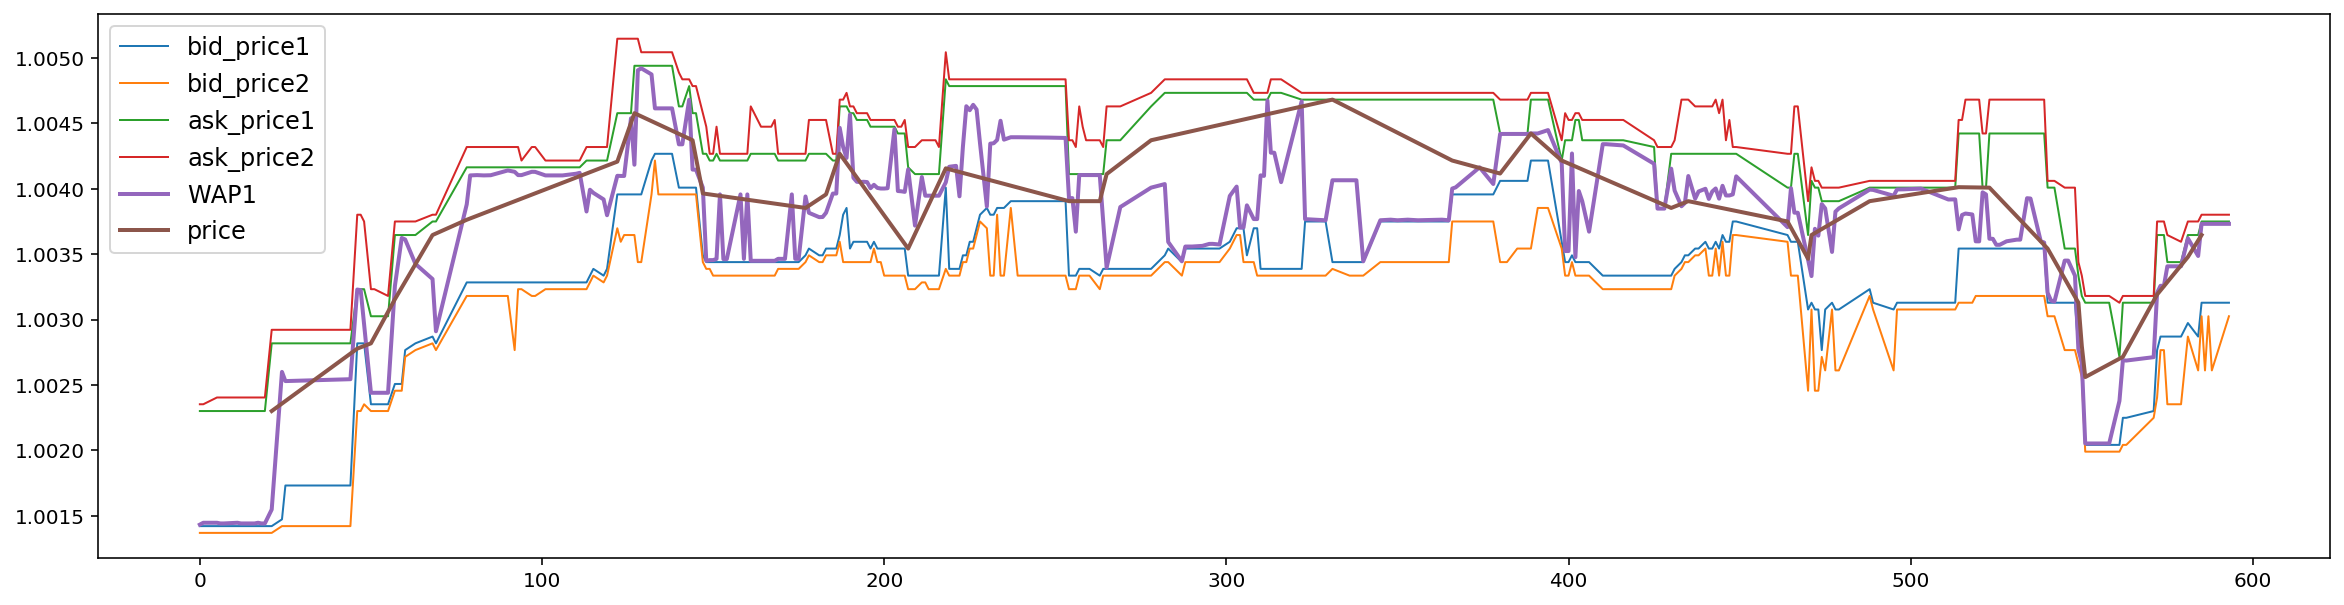

In [13]:
def ref_price_EDA(stock_id,train_test='train'): 
    print ('----    print input/book_test.parquet/stock_id=0/7832c05caae3489cbcbbb9b02cf61711.parquet file    --- \n')
    df_book = pq.read_table(get_price(stock_id, 'book', train_test)[0]).to_pandas()
    df_trade = pq.read_table(get_price(stock_id, 'trade', train_test)[0]).to_pandas()
    print ('***'*10,'  book  ','***'*10)
    print (df_book.head())
    print ('***'*10,'  trade  ','***'*10)
    print (df_trade.head())

    time_id = 5
    book_test =  df_book[df_book["time_id"]==time_id]
    trade_test =  df_trade[df_trade["time_id"]==time_id]

    book_test['WAP1']= WAP1(book_test)
    book_test['WAP2']= WAP2(book_test)
    
    
    #[(book, column name, linewidth)]
    samples = \
        [(book_test,'bid_price1',1.0)
        ,(book_test,'bid_price2',1.0)
        ,(book_test,'ask_price1',1.0)
        ,(book_test,'ask_price2',1.0)
        ,(book_test,'WAP1',2.0)
#         ,(book_test,'WAP2',3.0)
        ,(trade_test,'price',2.0)
        ]
    plt.figure(figsize=(20,5))
    for num, (book, col,lw) in enumerate(samples):
        plt.plot(book["seconds_in_bucket"],book[col],label=col,linewidth=lw)
    plt.legend(fontsize=12)
    plt.show()
    
ref_price_EDA(0)

id_is_same 0.0
max id is  32767
count time id 3830


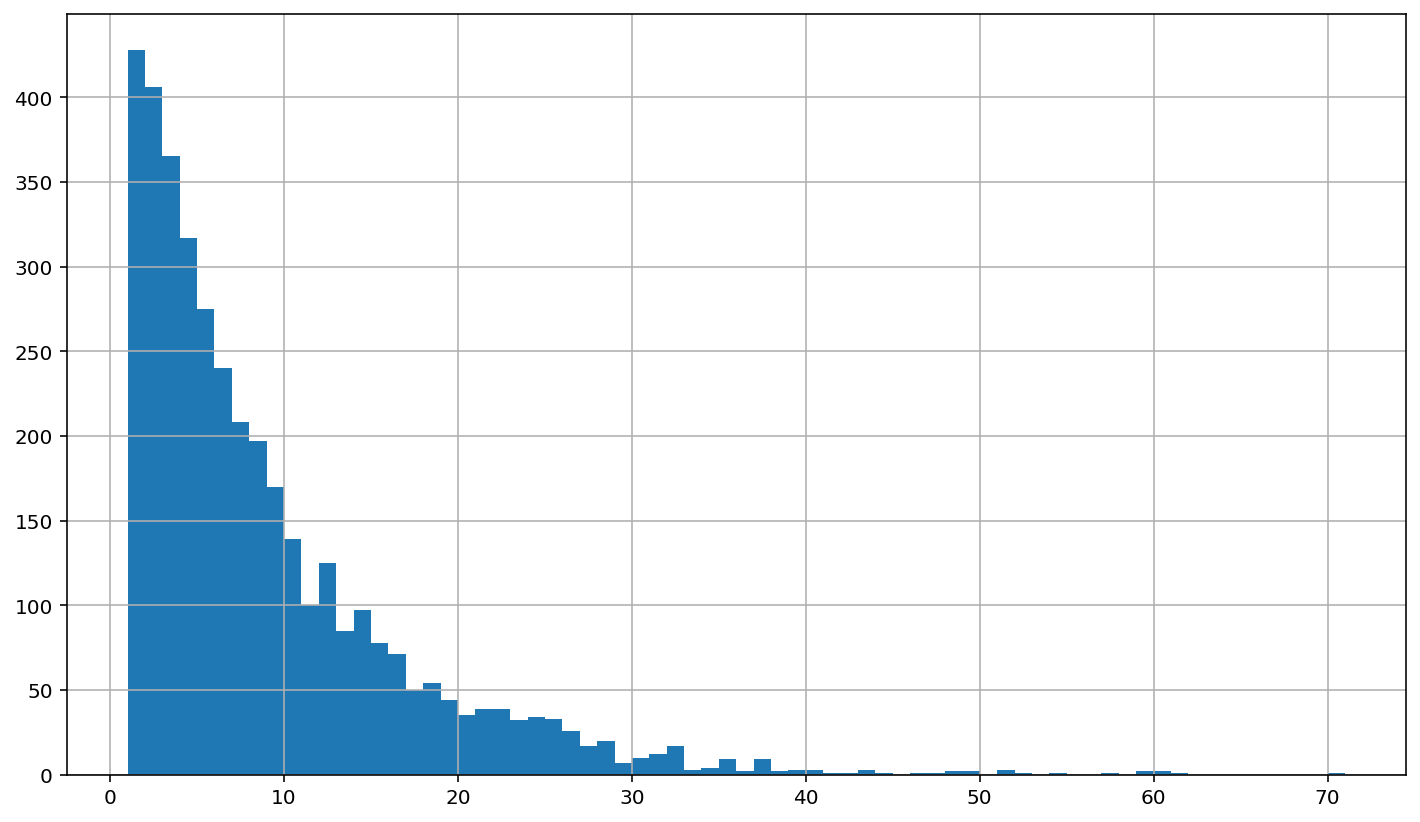

In [7]:
def ref_time_EDA():
    df_sample0=train.query("stock_id==0")
    df_sample10=train.query("stock_id==10")
    id_is_same = (df_sample10['time_id']-df_sample0['time_id']).abs().sum()
    
    print ('id_is_same',id_is_same)
    print ('max id is ',df_sample0['time_id'].max())
    print ('count time id', df_sample0['time_id'].nunique())
    
    df_sample0['time_id'].diff().hist(bins=70)
ref_time_EDA()

Ref 
1. 112 stocks,3 years of data, each data point represents 10 min bucket
2. each 10-min bucket has a corresponding time_id
3. time bins r discontinuous, should not use rolling functions
4. in the 10-mib bucket, not all book or trade has data in every sec. the distribution is different too
5. they will try simple LightGBM

our takeaways

Machine Learning Procedural Improvements:
1. Read the problem more carefuly, with extra attention to formulae (wap)
2. Plot the data, and plots of meta data to check our assumptions more carefully
3. Read the data again check for accidental overlaps between different sets of data

In [73]:
print(get_price(0, 'book', 'test'))
pq.read_table(get_price(0, 'book', 'test')[0]).to_pandas()

['input/book_test.parquet/stock_id=0/7832c05caae3489cbcbbb9b02cf61711.parquet']


,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,4,0,1.000049,1.000590,0.999656,1.000639,91,100,100,24
1,4,1,1.000049,1.000590,0.999656,1.000639,91,100,100,20
2,4,5,1.000049,1.000639,0.999656,1.000885,290,20,101,15


In [70]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler


def log_return(series):
    return np.log(series).diff()

def calc_book(stock_id, train_test):
    """    improvements: calculate following features only using the last 300 sec 
    train_test: str "train" or "test"
    """
    # df_trade = pq.read_table(get_price(stock_id, 'trade', train_test)[stock_id]).to_pandas()
    df_book = pq.read_table(get_price(stock_id, 'book', train_test)[0]).to_pandas()
    print('0000',df_book)
#     waited average price
    df_book['wap1']= WAP1(df_book)
    df_book['wap2']= WAP2(df_book)
    
    df_book['logret1']= df_book.groupby('time_id')['wap1'].apply(log_return)
    df_book['logret2']= df_book.groupby('time_id')['wap2'].apply(log_return)
    
    
    df_book['wap_balance'] = abs(df_book['logret1']-df_book['logret2'])
    df_book['ret_sqr'] = df_book['logret1']**2
    df_book['ret_sqr2'] = df_book['logret2']**2
    
    df_book['price_spread']= (df_book.ask_price1 - df_book.bid_price1 )* 2 / (df_book.ask_price1 + df_book.bid_price1)
    
    df_book['bid_spread'] = df_book['bid_price1']-df_book['bid_price2']
    df_book['ask_spread'] = df_book['ask_price1']-df_book['ask_price2']
    
    df_book['total_volume'] = df_book['bid_size1']+df_book['bid_size2']+df_book['ask_size1']+df_book['ask_size2']
    df_book['volume_spread'] = abs(df_book['bid_size1']+df_book['bid_size2']-df_book['ask_size1']-df_book['ask_size2'])

    print('11111',df_book)

    df_vol = df_book.groupby(['time_id']).agg \
        (
            vol=('ret_sqr',sum),
            wap = ('wap1',np.mean),
            wap_balance =('wap_balance',np.mean),
            price_spread = ('price_spread',np.mean),
            bid_spread = ('bid_spread',np.mean),
            ask_spread = ('ask_spread',np.mean),
            total_volume=('total_volume',np.mean),
            volume_spread=('volume_spread',np.mean),
        )
        
    
    print ('33333',df_vol)
    df_vol['vol_300'] = np.sqrt(df_book[df_book.seconds_in_bucket >= 300].groupby(['time_id']).agg(vol300=('ret_sqr',sum))['vol300'])
    df_vol['vol'] = np.sqrt(df_vol['vol'])
    df_vol['stock_id'] = stock_id    
    df_out = pd.merge(train,df_vol,on=['stock_id','time_id'])
    print ('444444',df_out)
    return df_out


def combine_realvol(train_test):
    sids = (stock_ids if train_test == 'train' else [0])
    book = [calc_book(stock_id,train_test) for stock_id in sids]
    print('222222', book)
    df_comb = pd.concat(book)
    return df_comb
        
        

def plot_price(df):
    print ('*'*10,'output','*'*10)
    print(df)

    print ('*'*10,'train','*'*10)
    print (train.head(5))
    
    plt.scatter(df.target,df.vol)
    
#     figure, axis = plt.subplots(1)
#     axis[0].scatter(df.target,df.vol)
#     axis[0].set_title("target")

    print ('*'*10,'cov matrix','*'*10)
    print(df.corr())


# calc_realvol(stock_id = 0,train_test='train')
df_out_test = combine_realvol('test')

0000    time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        4                  0    1.000049    1.000590    0.999656    1.000639   
1        4                  1    1.000049    1.000590    0.999656    1.000639   
2        4                  5    1.000049    1.000639    0.999656    1.000885   

   bid_size1  ask_size1  bid_size2  ask_size2  
0         91        100        100         24  
1         91        100        100         20  
2        290         20        101         15  
11111    time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        4                  0    1.000049    1.000590    0.999656    1.000639   
1        4                  1    1.000049    1.000590    0.999656    1.000639   
2        4                  5    1.000049    1.000639    0.999656    1.000885   

   bid_size1  ask_size1  bid_size2  ask_size2  ...   logret1   logret2  \
0         91        100        100         24  ...       NaN       NaN   

In [0]:
df_out = combine_realvol('train')

In [69]:
df_out_test = combine_realvol('test')

11111    time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        4                  0    1.000049    1.000590    0.999656    1.000639   
1        4                  1    1.000049    1.000590    0.999656    1.000639   
2        4                  5    1.000049    1.000639    0.999656    1.000885   

   bid_size1  ask_size1  bid_size2  ask_size2  ...   logret1   logret2  \
0         91        100        100         24  ...       NaN       NaN   
1         91        100        100         20  ...  0.000000  0.000026   
2        290         20        101         15  ...  0.000294  0.000251   

   wap_balance       ret_sqr      ret_sqr2  price_spread  bid_spread  \
0          NaN           NaN           NaN      0.000541    0.000393   
1     0.000026  0.000000e+00  6.981290e-10      0.000541    0.000393   
2     0.000044  8.655287e-08  6.280433e-08      0.000590    0.000393   

   ask_spread  total_volume  volume_spread  
0   -0.000049           315           

********** output **********
      stock_id  time_id    target       vol       wap  wap_balance  \
0            0        5  0.004136  0.004499  1.003725     0.000319   
1            0       11  0.001445  0.001204  1.000239     0.000121   
2            0       16  0.002168  0.002369  0.999542     0.000268   
3            0       31  0.002195  0.002574  0.998832     0.000218   
4            0       62  0.001747  0.001894  0.999619     0.000182   
...        ...      ...       ...       ...       ...          ...   
3825       126    32751  0.003461  0.003691  0.999582     0.000232   
3826       126    32753  0.003113  0.004104  1.002476     0.000278   
3827       126    32758  0.004070  0.003118  1.001082     0.000230   
3828       126    32763  0.003357  0.003661  1.001809     0.000209   
3829       126    32767  0.002090  0.002091  1.000272     0.000153   

      price_spread  bid_spread  ask_spread  total_volume  volume_spread  \
0         0.000852    0.000176   -0.000151    323.49668

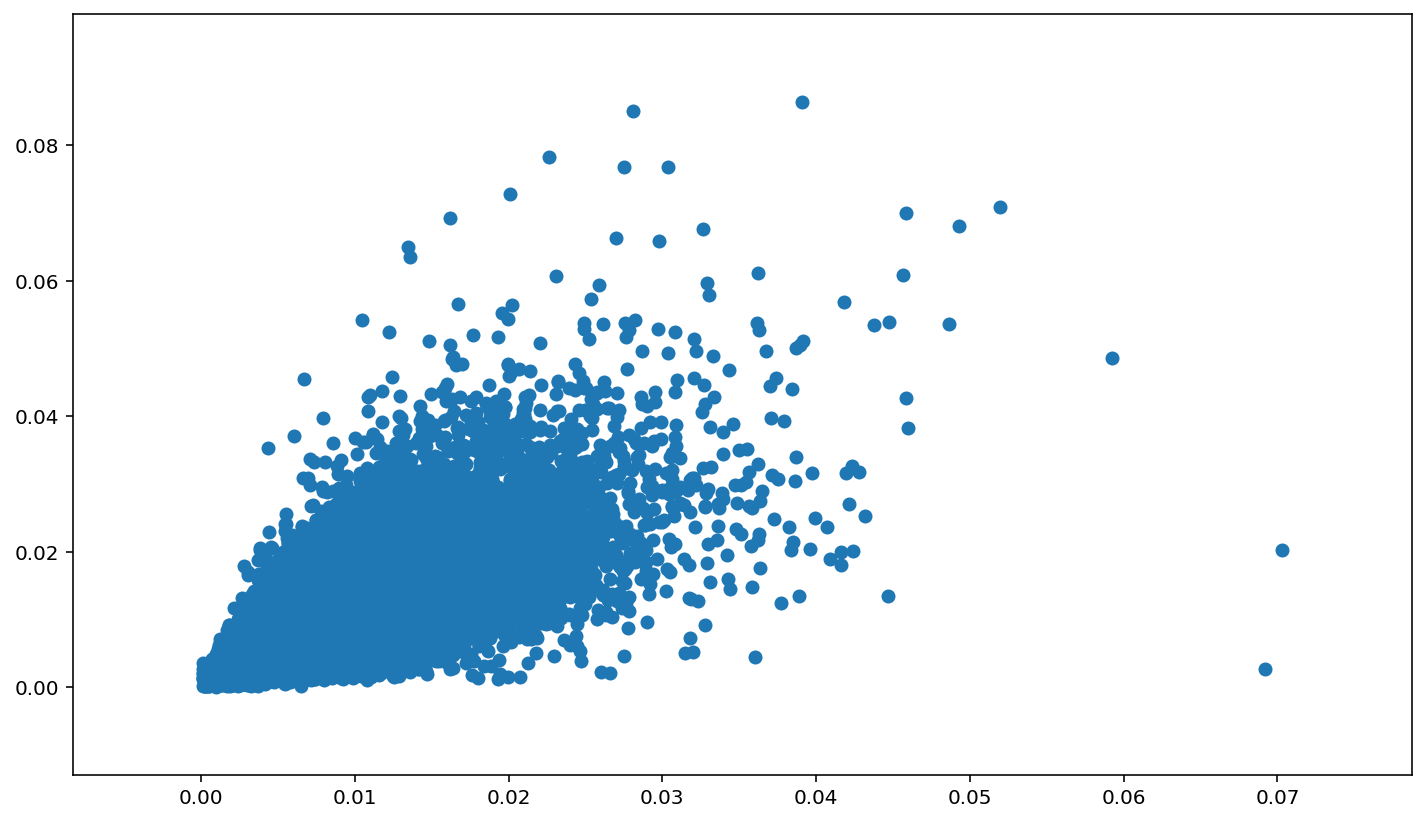

In [14]:
plot_price(df_out)

In [15]:
def cal_trade(stock_id, train_test):
    df_trade = pq.read_table(get_price(stock_id, 'trade', train_test)[0]).to_pandas()
    print (df_trade)
#     waited average price
    df_book['wap1']= WAP1(df_book)
    df_book['wap2']= WAP2(df_book)
    
    df_book['logret1']= df_book.groupby('time_id')['wap1'].apply(log_return)
    df_book['logret2']= df_book.groupby('time_id')['wap2'].apply(log_return)
    
    
    df_book['wap_balance'] = abs(df_book['logret1']-df_book['logret2'])
    df_book['ret_sqr'] = df_book['logret1']**2
    df_book['ret_sqr2'] = df_book['logret2']**2
    
    df_book['price_spread']= (df_book.ask_price1 - df_book.bid_price1 )* 2 / (df_book.ask_price1 + df_book.bid_price1)
    
    df_book['bid_spread'] = df_book['bid_price1']-df_book['bid_price2']
    df_book['ask_spread'] = df_book['ask_price1']-df_book['ask_price2']
    
    df_book['total_volume'] = df_book['bid_size1']+df_book['bid_size2']+df_book['ask_size1']+df_book['ask_size2']
    df_book['volume_spread'] = abs(df_book['bid_size1']+df_book['bid_size2']-df_book['ask_size1']-df_book['ask_size2'])
    
    df_vol = df_book.groupby(['time_id']).agg \
        (
            vol=('ret_sqr',sum),
            wap = ('wap1',np.mean),
            wap_balance =('wap_balance',np.mean),
            price_spread = ('price_spread',np.mean),
            bid_spread = ('bid_spread',np.mean),
            ask_spread = ('ask_spread',np.mean),
            total_volume=('total_volume',np.mean),
            volume_spread=('volume_spread',np.mean),
        )
    df_vol['vol_300'] = np.sqrt(df_vol['vol'])
    df_vol['vol'] = np.sqrt(df_vol['vol'])
    df_vol['stock_id'] = stock_id    
    df_out = pd.merge(train,df_vol,on=['stock_id','time_id'])
    return df_out
 

In [24]:
def transform_table(df):
    
    df = df_out.pivot(index="stock_id", columns="time_id", values="vol")
    df['mean']=df.std(axis=1)
    df.index.name='id'
    df['stock_id']=df.index
    df = pd.merge(df_out, df[['mean','stock_id']], left_on='stock_id', right_on='stock_id')
    return df
    
df_out= transform_table(train)

In [25]:
from sklearn.metrics import mean_absolute_error

def LRG_model(df):
    X = df[['vol','mean']]
    y = pd.DataFrame(df.target)


    import statsmodels.api as sm
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print(est2.summary())
    
    
    reg = LinearRegression().fit(X.values, y.values)
    y_pred = reg.predict(X.values)
    print ('score',reg.score(X, y))
    print ('coef',reg.coef_, '  intercept',)
    print ('MAE',mean_absolute_error(y_pred, y))
    
    y['stock_id'] = df['stock_id']
    y['pred'] = y_pred
    y['residual'] = y['target']-y['pred']
    y['mean'] = y.residual.rolling(20).mean()
    y['std'] = y.residual.rolling(20).std()


#     figure, axis = plt.subplots(2)

    
#     axis[0].plot(y['mean'])
#     axis[0].set_title("mean")
    
#     axis[1].plot(y['std'])
#     axis[1].set_title("std")
#     plt.show()

# df_out=EDA()
LRG_model(df=df_out)

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                 7.232e+05
Date:                Sun, 14 Nov 2021   Prob (F-statistic):               0.00
Time:                        16:22:48   Log-Likelihood:             2.2087e+06
No. Observations:              428932   AIC:                        -4.417e+06
Df Residuals:                  428929   BIC:                        -4.417e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.886e-05   7.57e-06      3.810      0.0

/projects/9251e88a-4765-4a7f-8e9d-7788e65f33ea/.local/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [32]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

def GradientBoost_model(df):
    model = XGBRegressor()

    X = df[['vol','mean','wap_balance','price_spread','mean_x','mean_y']]
    y = pd.DataFrame(df.target)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
    
    
    gb = model.fit(X_train,y_train)
#     y_train_pred = gb.predict(X_train)
    y_test_pred = gb.predict(X_test)
        
    print ('train score',gb.score(X_train, y_train))
    print ('test score',gb.score(X_test, y_test))

    #print ('coef',gb.coef_, '  intercept',)
    print ('MAE',mean_absolute_error(y_test_pred, y_test))
    
    
    

GradientBoost_model(df=df_out)
df_out.head()

train score 0.8265776597934793
test score 0.7867404226961416
MAE 0.0007834164268666089


,stock_id,time_id,target,vol,wap,wap_balance,price_spread,bid_spread,ask_spread,total_volume,volume_spread,vol_300,mean_x,mean_y,mean
0,0,5,0.004136,0.004499,1.003725,0.000319,0.000852,0.000176,-0.000151,323.496689,134.894040,0.002953,0.003698,0.003698,0.003698
1,0,11,0.001445,0.001204,1.000239,0.000121,0.000394,0.000142,-0.000135,411.450000,142.050000,0.000981,0.003698,0.003698,0.003698
2,0,16,0.002168,0.002369,0.999542,0.000268,0.000725,0.000197,-0.000198,416.351064,141.414894,0.001295,0.003698,0.003698,0.003698
3,0,31,0.002195,0.002574,0.998832,0.000218,0.000860,0.000190,-0.000108,435.266667,146.216667,0.001776,0.003698,0.003698,0.003698
4,0,62,0.001747,0.001894,0.999619,0.000182,0.000397,0.000191,-0.000109,343.221591,123.846591,0.001520,0.003698,0.003698,0.003698


In [28]:
test

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [29]:
train

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747
...,...,...,...
428927,126,32751,0.003461
428928,126,32753,0.003113
428929,126,32758,0.004070
428930,126,32763,0.003357


In [50]:
df_out_test

,stock_id,time_id,target,vol,wap,wap_balance,price_spread,bid_spread,ask_spread,total_volume,volume_spread,vol_300
